In [20]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

# Improving HACI.

I want to understand the method to a greater extent. What I want to understand further:
- How the splitting of the upper and lower bound is effected by the change of alpha.
    - I think that you need two updates as otherwise your are lengthning one and shortening the other
    

In [21]:
from scipy.optimize import minimize

class hACP(AdaptiveCP):
    '''This class will implement the hACP method.'''

    @staticmethod
    def pinball_loss_function(target, y, y_hat):
        return (target * (y - y_hat)) - min(0, (y - y_hat))

    # New Method.
    def conditional_quantile_loss(self, params: list, target: float, dataset: list[tuple]):
        ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

        # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
        zipped_data_set = zip(dataset[0][1:], np.diff(dataset[1])[1:]) # Is this correct what are we calculating?
        loss_list = [hACP.pinball_loss_function(target, y, (params[0] + params[1] * var)) for var, y in zipped_data_set]

        return sum(loss_list)

    def HACI(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
        ''' Implementation of the Adaptive Conformal Prediction method.'''
        xpred, varpred, y = timeseries_with_var_data

        alpha_t_list = [self.coverage_target]
        lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
        params_t_list = {'lower': [(0,0)],
                         'upper': [(0,0)]} # params list. with the inital guess.


        # We will use the difference as the scores. Hence positve means the val is above.
        All_scores = xpred - y

        err_t_list = []
        conformal_sets_list = []

        if startpoint is None:
            if custom_interval is not None:
                startpoint = max(custom_interval, self.interval_size) + 1
            else:
                startpoint = self.interval_size + 1

        for i in range(startpoint, len(All_scores)):
            # We need to replace this.
        
            # Fitting the upper and lower parameters.
            lower_params = minimize(self.conditional_quantile_loss, params_t_list['lower'][-1], 
                                    bounds=lower_bound, args=(self.coverage_target/2, (varpred[i-self.interval_size:i], y[i-self.interval_size:i]))).x
            upper_params = minimize(self.conditional_quantile_loss, params_t_list['upper'][-1],
                                    bounds=upper_bound, args=(1-self.coverage_target/2, (varpred[i-self.interval_size:i], y[i-self.interval_size:i]))).x
        
            params_t_list['lower'].append(lower_params)
            params_t_list['upper'].append(upper_params)

            # Using fitted values to create the conformal set.
            lower_bound_t = lower_params[0] + lower_params[1] * varpred[i]
            upper_bound_t = upper_params[0] + upper_params[1] * varpred[i]
            
            conformal_set = (xpred[i] + min(0, lower_bound_t), xpred[i] + max(0, upper_bound_t))

            conformal_sets_list.append(conformal_set)

            # Updating the alpha_t.
            error_t = AdaptiveCP.err_t(y[i], conformal_set)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        # Calculating different metrics.
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
            'model': title if title is not None else 'ACI',
            'coverage_target': self.coverage_target,
            'gamma': gamma,
            'realised_interval_coverage': realised_interval_coverage,
            'alpha_t_list': alpha_t_list,
            'average_prediction_interval': average_prediction_interval,
            'conformal_sets': conformal_sets_list,
            'error_t_list': err_t_list, 
            'interval_size': self.interval_size,
            'params_t_list': params_t_list,

        }
    
    def score_conditional_quantile_loss(self, params: list, target: float, dataset: list[tuple]):
        ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

        # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
        zipped_data_set = zip(dataset[0], dataset[1]) 
        loss_list = [hACP.pinball_loss_function(target, y, (params[0] + params[1] * var)) for var, y in zipped_data_set]

        return sum(loss_list)
    
    def oneside_HACI(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
            ''' Implementation of the Adaptive Conformal Prediction method.'''
            xpred, varpred, y = timeseries_with_var_data

            alpha_t_list = [self.coverage_target]
            lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
            params_t_list = {'lower': [(0,0)],
                            'upper': [(0,0)]} # params list. with the inital guess.


            # We will use the difference as the scores. Hence positve means the val is above.
            All_scores = self.score_function(xpred, y)

            err_t_list = []
            conformal_sets_list = []

            if startpoint is None:
                if custom_interval is not None:
                    startpoint = max(custom_interval, self.interval_size) + 1
                else:
                    startpoint = self.interval_size + 1

            for i in range(startpoint, len(All_scores)):
                # We need to replace this.
            
                # Fitting the upper and lower parameters.
                fitted_params = minimize(self.conditional_quantile_loss, params_t_list['lower'][-1], 
                                        bounds=lower_bound, args=(self.coverage_target, (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
            
                params_t_list['lower'].append(fitted_params)
                params_t_list['upper'].append(fitted_params)

                # Using fitted values to create the conformal set.
                pred_score = fitted_params[0] + fitted_params[1] * varpred[i]
                
                conformal_set = (self.neg_inverse_score(xpred[i], pred_score), self.pos_inverse_score(xpred[i], pred_score))

                conformal_sets_list.append(conformal_set)

                # Updating the alpha_t.
                error_t = AdaptiveCP.err_t(y[i], conformal_set)
                err_t_list.append(error_t)

                alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            # Calculating different metrics.
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                'model': title if title is not None else 'ACI',
                'coverage_target': self.coverage_target,
                'gamma': gamma,
                'realised_interval_coverage': realised_interval_coverage,
                'alpha_t_list': alpha_t_list,
                'average_prediction_interval': average_prediction_interval,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list, 
                'interval_size': self.interval_size,
                'params_t_list': params_t_list,

            }
    


    


In [22]:
# Creating the method for creating the data.

def create_nomrmal_cheb_data(length: int, model_error: float = 0.1, time_series_function: callable = lambda x: x, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''  
    minv, maxv = var_range

    true_variance_array = np.random.uniform(minv, maxv, length)
    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + np.random.uniform(model_error*minv, model_error*maxv, length)
    time_series_normal = time_series_function(corresponding_normal)

    # Now we need to return as xpred, varpred, y
    # The variance is the prediction for the same time step. 
    # Hence you need to ignore the first value for the variance as you do for the true value.
    
    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])

def create_hetroskedatic_cheb_data(length: int, model_error: float = 0.1, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''  

    # We will simulate a random walk for the variance. Might do a exponenital random walk as 
    # then no issues with negative values.

    exp_random_walk = np.random.normal(0, 0.1, length)
    true_variance_array = np.exp(np.cumsum(exp_random_walk))

    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + (true_variance_array * np.random.uniform(model_error, 2-model_error, length))
    time_series_normal = np.cumsum(corresponding_normal)

    # Now we need to return as xpred, varpred, y

    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])


def xvy_from_y(series, lookback: int = -1):
    '''This function will create the x, var and y series from the y series.'''
    
    if lookback == -1:
        lookback = len(series) # This results in all data being used.

    x = series[:-1]
    y = series[1:]

    # Calculating the series of sample variances of a length lookback.
    var = [np.var(series[max(0, i - lookback):i+1]) for i in range(1, len(series))]

    return x, var, y

def xvy_from_ACP(dataset, lookback: int = -1):
    lookback = len(dataset) if lookback == -1 else lookback
    final = []
    for x, y in dataset:
        var = [np.var(x[max(0, i - lookback):i+1]) for i in range(1, len(x))] # We need to ignore the first value.
        final.append((x[1:], var, y[1:]))

    return final

def xvy_correction(dataset):
    return [(x[0][1:], x[1][1:]) for x in dataset]



In [ ]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

In [23]:
h = hACP(0.2, 200)

## He will investiagate on stock data.

In [24]:
all_stock_data = ACP_data.stock_data(100)

In [25]:
stock_data = [all_stock_data[4]]

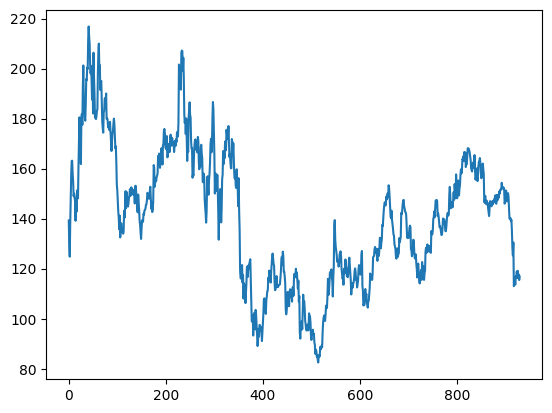

In [26]:
plt.plot(stock_data[0][1])

In [27]:
cleaned_stock_data = xvy_from_ACP(stock_data, 10)[0]
corrected_stock_data = xvy_correction(stock_data)[0]

In [28]:
stock_result = h.HACI(cleaned_stock_data, gamma=0.05, title='hACP')

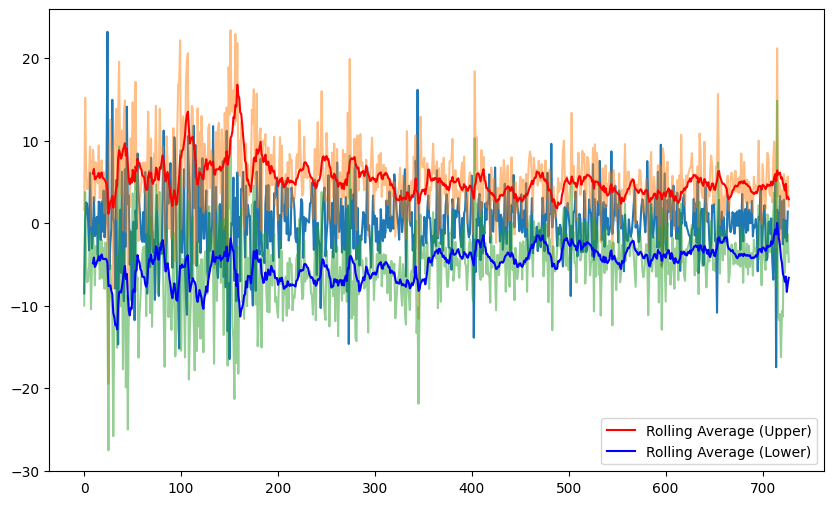

In [29]:
plt.figure(figsize=(10, 6))  # Set the size of the figure
plot_stock_result = cleaned_stock_data[2][201:]

plt.plot(np.diff(plot_stock_result))

upper = np.array([x[1] for x in stock_result['conformal_sets']])
lower = np.array([x[0] for x in stock_result['conformal_sets']])

plt.plot(upper - plot_stock_result, alpha=0.5)
plt.plot(lower - plot_stock_result, alpha=0.5)

# Plotting rolling averages
rolling_avg_upper = pd.Series(upper - plot_stock_result).rolling(window=10).mean()
rolling_avg_lower = pd.Series(lower - plot_stock_result).rolling(window=10).mean()

plt.plot(rolling_avg_upper, color='red', label='Rolling Average (Upper)')
plt.plot(rolling_avg_lower, color='blue', label='Rolling Average (Lower)')

plt.legend()

plt.show()

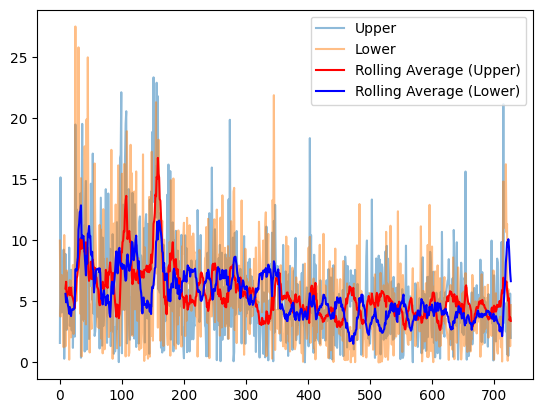

In [30]:
# I want to see if when one gets smaller the other gets bigger.

plt.plot(abs(upper - plot_stock_result ), label='Upper', alpha=0.5)
plt.plot(abs(lower - plot_stock_result ), label='Lower', alpha=0.5)

rolling_avg_upper = pd.Series(abs(upper - plot_stock_result )).rolling(window=10).mean()
rolling_avg_lower = pd.Series(abs(lower - plot_stock_result )).rolling(window=10).mean()

plt.plot(rolling_avg_upper, color='red', label='Rolling Average (Upper)')
plt.plot(rolling_avg_lower, color='blue', label='Rolling Average (Lower)')

plt.legend()
plt.show()

In [31]:
# I want to test whether they are anitperiodic.
lower_av = pd.Series(rolling_avg_lower) 
upper_av = pd.Series(rolling_avg_upper)

print(lower_av.corr(upper_av))
print(upper_av.corr(lower_av))

0.5103042269871185
0.5103042269871186


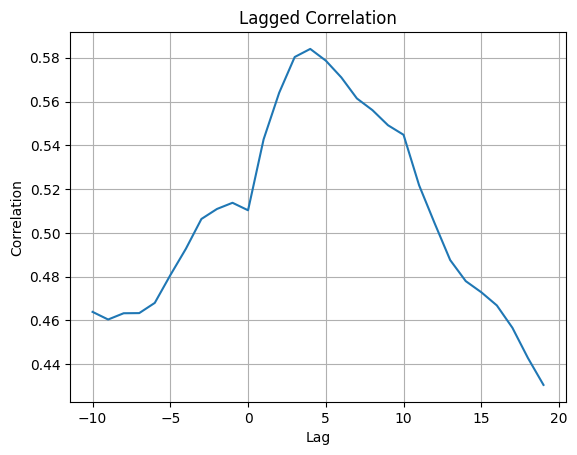

In [32]:
lags = range(-10, 20)  # Define range of lags
correlations = [lower_av.corr(upper_av.shift(lag)) for lag in lags]

plt.plot(lags, correlations)
plt.title('Lagged Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [33]:
oneside_stock_result = h.oneside_HACI(cleaned_stock_data, gamma=0.02, title='hACP')


In [34]:
print(oneside_stock_result['conformal_sets'])

[(np.float64(170.65394789240108), np.float64(164.84605210759892)), (np.float64(176.023433856377), np.float64(169.99655515729486)), (np.float64(167.40719086915965), np.float64(161.59280913084035)), (np.float64(167.5547394591116), np.float64(161.92527152721652)), (np.float64(170.06742044100505), np.float64(164.43257955899495)), (np.float64(172.4710178756961), np.float64(166.72899433133514)), (np.float64(172.77541005707354), np.float64(167.1645923843327)), (np.float64(169.32216110788818), np.float64(164.01783523000245)), (np.float64(175.4620734904785), np.float64(170.0379265095215)), (np.float64(176.36423595103722), np.float64(170.79576771107216)), (np.float64(173.2429942641322), np.float64(167.7570057358678)), (np.float64(171.89672421087434), np.float64(166.46326114068816)), (np.float64(175.07533729678212), np.float64(169.56467735165538)), (np.float64(173.41316621163395), np.float64(168.06684477469418)), (np.float64(172.35060944495368), np.float64(167.1693795687182)), (np.float64(172.241

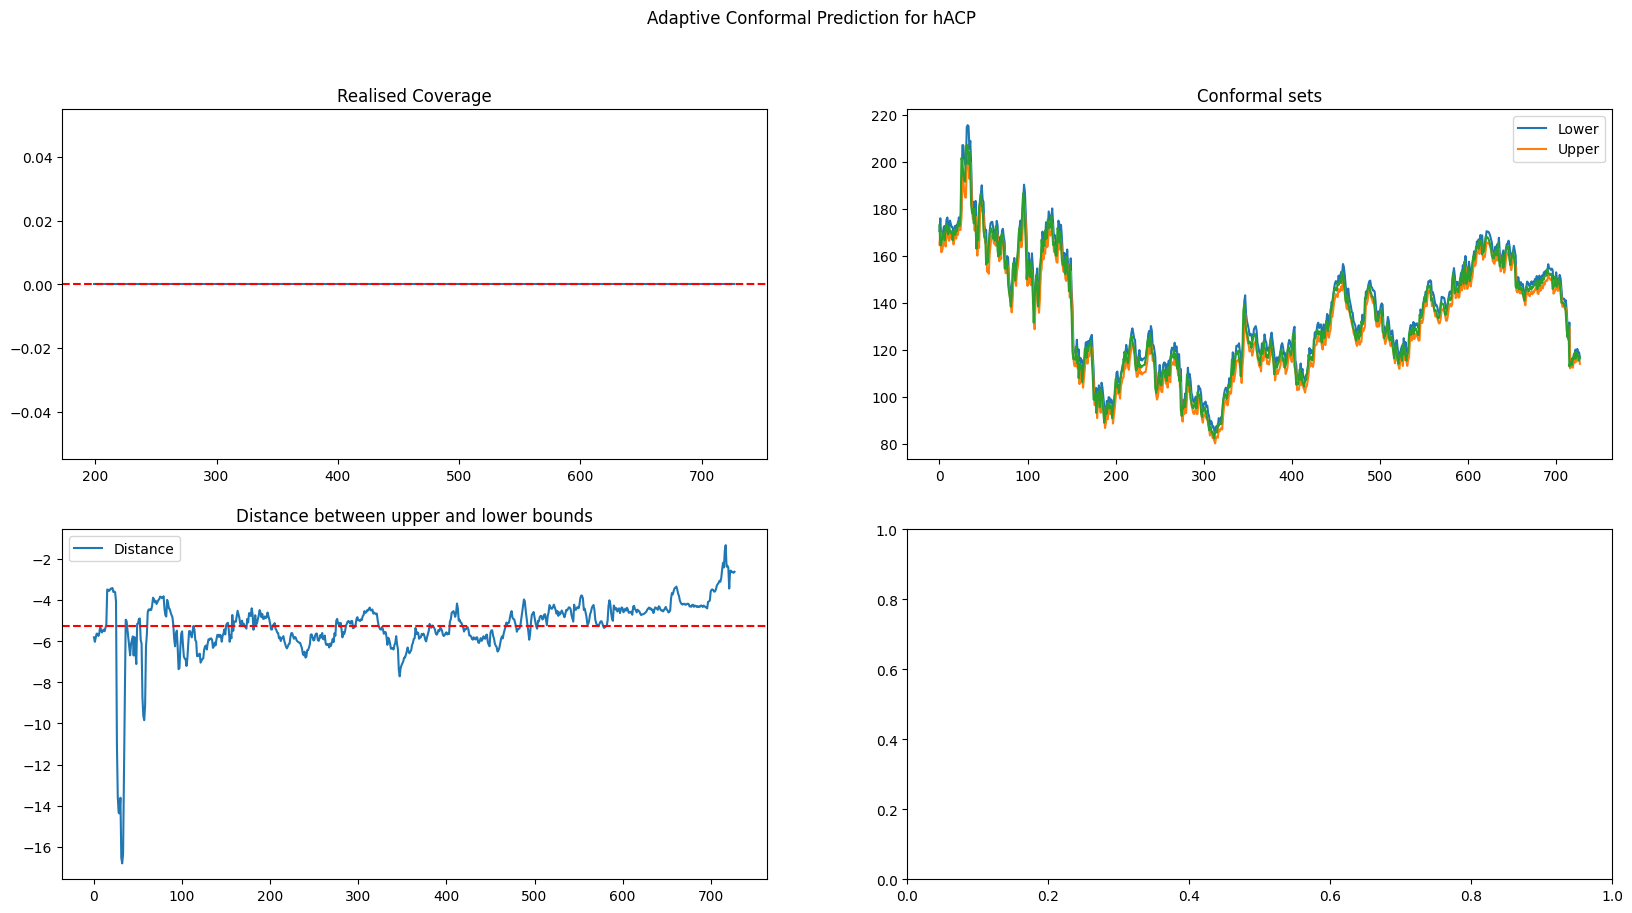

In [35]:
ACP_plots.one_plot(oneside_stock_result, cleaned_stock_data[2])